<a href="https://colab.research.google.com/github/AlexanderLontke/ssl-remote-sensing/blob/segmentation-refactoring/notebooks/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pretext Task: VAE

In [4]:
# !pip install ssl_remote_sensing@git+https://github.com/AlexanderLontke/ssl-remote-sensing.git@segmentation-refactoring

In [7]:
# !pip install wandb

In [2]:
import wandb

wandb.login()

wandb: Currently logged in as: xuemei-jiang. Use `wandb login --relogin` to force relogin


True

In [119]:
# TODO: change path
from ssl_remote_sensing.pretext_tasks.vae.utils import (
    reproducibility,
    batch_mean_and_sd,
    imshow,
    print_model,
)
from ssl_remote_sensing.models.ResNet18 import resnet18_encoder, resnet18_decoder
from ssl_remote_sensing.pretext_tasks.vae.model import VariationalAutoencoder

# from ssl_remote_sensing.downstream_tasks.classification import DownstreamClassificationNet

Adpated From: https://github.com/chenjie/PyTorch-CIFAR-10-autoencoder/blob/master/main.py

## Set up

In [106]:
# Numpy
import numpy as np

# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

# Torchvision
import torchvision
import torchvision.transforms as transforms


# Matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

# OS
import os
import argparse

from torch import Tensor
from torchvision.datasets import EuroSAT
from torch.utils.data import DataLoader
from torch.utils.data import random_split

from torch.multiprocessing import cpu_count

import rasterio as rio
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import cv2
from albumentations.pytorch import ToTensorV2
import albumentations as A

Machine setup

In [6]:
# Machine setup
available_gpus = torch.cuda.device_count()
print("available_gpus:", available_gpus)

available_gpus: 1


In [7]:
# set cpu or gpu enabled device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu").type

In [8]:
device

'cuda'

Saved model path setup

In [9]:
if not os.path.exists("./saved_models"):
    os.mkdir("./saved_models")

In [10]:
# os.getcwd()

In [11]:
save_model_path = os.path.join(os.getcwd(), "saved_models/")
# save_model_path

## Hyperparameter setup

In [12]:
# Model Setup
class Hparams:
    def __init__(self):
        self.pretext_epochs = 50  # number of training epochs for pretext tasks
        self.classification_epochs = 10
        self.segmentation_epochs = 10
        self.seed = 1234  # randomness seed
        self.save = "./saved_models/"
        self.gradient_accumulation_steps = 1  # gradient accumulation steps
        self.batch_size = 16
        self.lr = 1e-3
        self.weight_decay = 1e-6
        self.latent_dim = 256
        self.optim = "Adam"
        self.embedding_size = 128  # papers value is 128
        self.temperature = 0.5  # 0.1 or 0.5
        self.weight_decay = 1e-6
        self.cuda = True  # use coda
        self.transform = False

In [13]:
train_config = Hparams()

In [17]:
reproducibility(train_config)

Directory setup

In [38]:
# #autoencoder_dir = "./weights/autoencoder.pkl"

# weights_dir = "./weights/"
# #autoencoder_path_name = "autoencoder.pkl"
# autoencoder_path_name = "autoencoder.pth"
# classification_path_name = "classification_model.pth"
# segmentation_path_name = "segmentation_model.pth"

# autoencoder_dir = os.path.join(weights_dir,autoencoder_path_name)
# classification_dir = os.path.join(weights_dir,classification_path_name)
# segmentation_dir = os.path.join(weights_dir,segmentation_path_name)

# # segmentation_autoencoder_dir = "./weights/autoencoder.pkl"

## Data

Description: EuroSAT, RGB, Normalized

In [31]:
classes = (
    "AnnualCrop",
    "Forest",
    "HerbaceousVegetation",
    "Highway",
    "Industrial",
    "Pasture",
    "PermanentCrop",
    "Residential",
    "River",
    "SeaLake",
)

In [19]:
# means = [87.81586935763889, 96.97416420717593, 103.98142336697049]
# stds = [51.67849701591506, 34.908630837585186, 29.465280593587384]

Calculation of mean and sd: https://www.binarystudy.com/2022/04/how-to-normalize-image-dataset-inpytorch.html

In [20]:
means = [0.3444, 0.3803, 0.4078]
stds = [0.2037, 0.1366, 0.1148]

In [23]:
if train_config.transform:

    transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(
                mean=means, std=stds
            ),  # params computed from the eurosat data
        ]
    )
else:
    transform = transforms.Compose(
        [
            transforms.ToTensor(),
        ]
    )

In [22]:
dataset = EuroSAT("./", transform=transform, download=True)
print("[LOG] Total number of images: {}".format(len(dataset)))
print("[LOG] Size of the image is: {}".format(dataset[0][0].shape))

[LOG] Total number of images: 27000
[LOG] Size of the image is: torch.Size([3, 64, 64])


In [25]:
train_set, val_set = random_split(dataset, [21600, 5400])

In [26]:
train_loader = DataLoader(
    dataset=train_set, batch_size=train_config.batch_size, num_workers=cpu_count()
)

val_loader = DataLoader(
    dataset=val_set, batch_size=train_config.batch_size, num_workers=cpu_count()
)
print(f"[LOG] Batch size is {train_config.batch_size}")
print("[LOG] Total number of batches in the trainloader: %d" % len(train_loader))
print("[LOG] Total number of batches in the trainloader: %d" % len(val_loader))

[LOG] Batch size is 16
[LOG] Total number of batches in the trainloader: 1350
[LOG] Total number of batches in the trainloader: 338


In [27]:
# TODO: add funciton to compte means and tds
mean, std = batch_mean_and_sd(train_loader)
print("mean and std: \n", mean, std)

mean and std: 
 tensor([0.3435, 0.3800, 0.4075]) tensor([0.2036, 0.1367, 0.1150])


### Plot images

In [42]:
# def imshow(img):
#     fig, ax = plt.subplots(1, figsize=(15,15))
#     npimg = img.cpu().numpy()
#     plt.axis('off')
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     plt.show()

GroundTruth:
 Pasture Residential SeaLake Highway SeaLake Industrial AnnualCrop HerbaceousVegetation 
 River Forest AnnualCrop Industrial Forest HerbaceousVegetation Highway


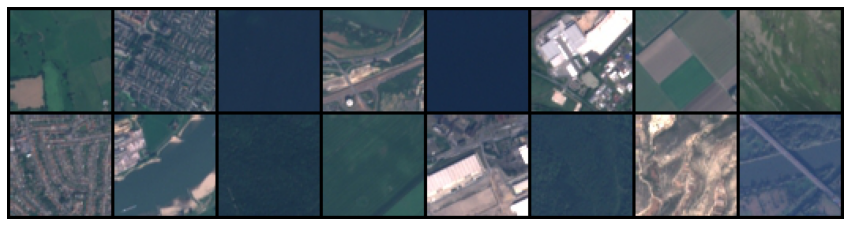

In [43]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(
    "GroundTruth:\n",
    " ".join("%5s" % classes[labels[j]] for j in range(8)),
    "\n",
    " ".join("%5s" % classes[labels[j]] for j in range(9, 16)),
)
imshow(torchvision.utils.make_grid(images))

## Model

In [34]:
# set latent dimension
d = train_config.latent_dim
print("[LOG] Latent dimension for VAE is: ", d)

[LOG] Latent dimension for VAE is:  256


In [48]:
# class VariationalAutoencoder(nn.Module):
#     def __init__(self,enc_out_dim = 512,latent_dim=None, input_height=64, config = None):
#         super().__init__()

#         self.encoder = resnet18_encoder()
#         self.decoder = resnet18_decoder(
#             latent_dim=latent_dim,
#             input_height=input_height
#         )

#         # distribution parameters
#         self.fc_mu = nn.Linear(enc_out_dim, latent_dim)
#         self.fc_var = nn.Linear(enc_out_dim, latent_dim)

#         # for the gaussian likelihood
#         self.log_scale = nn.Parameter(torch.Tensor([0.0]))

#     def configure_optimizers(self,config):
#         # set optimizer
#         if config.optim == "Adam":
#           # set learning rate
#           return torch.optim.Adam(self.parameters(), lr=config.lr)

#     def gaussian_likelihood(self, x_hat, logscale, x):
#         scale = torch.exp(logscale)
#         mean = x_hat
#         dist = torch.distributions.Normal(mean, scale)

#         # measure prob of seeing image under p(x|z)
#         log_pxz = dist.log_prob(x)
#         return log_pxz.sum(dim=(1, 2, 3))

#     def kl_divergence(self, z, mu, std):
#         # --------------------------
#         # Monte carlo KL divergence
#         # --------------------------
#         # 1. define the first two probabilities (in this case Normal for both)
#         p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
#         q = torch.distributions.Normal(mu, std)

#         # 2. get the probabilities from the equation
#         log_qzx = q.log_prob(z)
#         log_pz = p.log_prob(z)

#         # kl
#         kl = (log_qzx - log_pz)
#         kl = kl.sum(-1)
#         return kl

#     def training_step(self, batch):
#         x = batch
#         x = x.float()

#         # encode x to get the mu and variance parameters
#         x_encoded = self.encoder(x)
#         mu, log_var = self.fc_mu(x_encoded), self.fc_var(x_encoded)

#         # sample z from q
#         std = torch.exp(log_var / 2)
#         q = torch.distributions.Normal(mu, std)
#         z = q.rsample()

#         # decoded
#         x_hat = self.decoder(z)

#         # reconstruction loss
#         recon_loss = self.gaussian_likelihood(x_hat, self.log_scale, x)

#         # kl
#         kl = self.kl_divergence(z, mu, std)

#         # elbo
#         elbo = (kl - recon_loss)
#         elbo = elbo.mean()

#         return x_encoded,x_hat,elbo

In [58]:
# Create model
# model has been moved to device
model = VariationalAutoencoder(latent_dim=d, config=train_config)
model = model.to(device)
# print_model(autoencoder.encoder, autoencoder.decoder)

In [ ]:
# print_model(autoencoder.encoder,autoencoder.encoder.decoder)

In [59]:
# check if model is on cuda
print("Is model on cuda? ", next(model.parameters()).is_cuda)

Is model on cuda?  True


In [60]:
# init the number of model parameters
num_params = 0

# iterate over the distinct parameters
for param in model.parameters():

    # collect number of parameters
    num_params += param.numel()

# print the number of model paramters
print("[LOG] Number of to be trained ResNet model parameters: {}.".format(num_params))

[LOG] Number of to be trained ResNet model parameters: 20068993.


In [71]:
# Training and testing the VAE

epochs = train_config.pretext_epochs

for epoch in range(1, epochs + 1):
    # Training
    if epoch > 0:  # test untrained net first
        model.train()
        train_loss = 0
        for y, _ in train_loader:
            y = y.to(device)
            # ===================forward=====================
            loss = model.training_step(y)[2]
            train_loss += loss.item() / len(train_loader)
            # ===================backward====================
            model.configure_optimizers(config=train_config).zero_grad()
            loss.backward()
            model.configure_optimizers(config=train_config).step()
        # print(f'====> Epoch: {epoch} Average training loss: {train_loss :.4f} Average validation loss: {val_loss :.4f }')

        # Specify you are in evaluation mode
        model.eval()
        with torch.no_grad():
            val_loss = 0
            for y, _ in val_loader:
                y = y.to(device)
                # labels = labels.to(device)
                # calculate outputs by running images through the network
                output = model.training_step(y)[2]
                val_loss += output.item() / len(val_loader)
                # the class with the highest energy is what we choose as prediction
                # collect mini-batch reconstruction loss
            # ===================log========================
        print(
            f"====> Epoch: {epoch} Average training loss: {train_loss :.4f} Average validation loss: {val_loss :.4f}"
        )

        if epoch == 1:
            best_val_loss = val_loss
        else:
            if val_loss <= best_val_loss:
                best_val_loss = val_loss
                # Save only the best model
                save_weights_path = os.path.join(save_model_path, "autoencoder.pth")
                torch.save(model.state_dict(), save_weights_path)
                print("Saving Model...")
print("Finished Training")

====> Epoch: 1 Average training loss: -11153.4467 Average validation loss: -4017.5679
====> Epoch: 2 Average training loss: -11536.6478 Average validation loss: -9187.1701
Saving Model...


KeyboardInterrupt: ignored

In [ ]:
# print('Saving Model...')
# # if not os.path.exists('./weights'):
# #     os.mkdir('./weights')
# print("Saved path is ", autoencoder_dir)
# torch.save(autoencoder.state_dict(), autoencoder_dir)

GroundTruth:  Pasture Residential SeaLake Highway SeaLake Industrial AnnualCrop HerbaceousVegetation Residential River Forest AnnualCrop Industrial Forest HerbaceousVegetation Highway


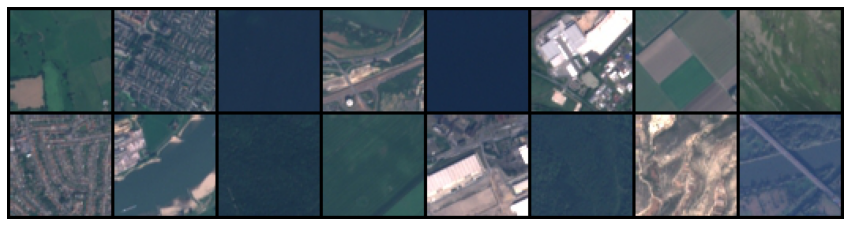

In [72]:
model.load_state_dict(torch.load(os.path.join(save_model_path, "autoencoder.pth")))
dataiter = iter(train_loader)
images, labels = dataiter.next()
print("GroundTruth: ", " ".join("%5s" % classes[labels[j]] for j in range(16)))
imshow(torchvision.utils.make_grid(images))
images = Variable(images.cuda())

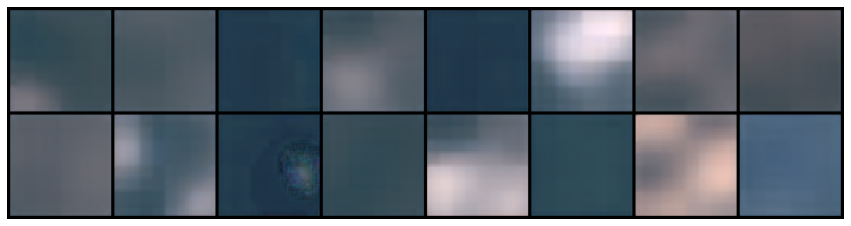

In [73]:
decoded_imgs = model.training_step(images)[1]
imshow(torchvision.utils.make_grid(decoded_imgs))

# Downstream task

## Load best model

In [76]:
import os
import torch


def best_model_loader(pretext_model, saved_model_path):

    # restore pre-trained model snapshot
    best_model_name = saved_model_path

    # load state_dict from path
    state_dict_best = torch.load(best_model_name, map_location=torch.device("cpu"))

    # init pre-trained model class
    best_model = pretext_model

    # load pre-trained models
    best_model.load_state_dict(state_dict_best)

    return best_model

In [77]:
# best_model = best_model_loader(autoencoder,"./weights/","autoencoder.pkl")
best_model = best_model_loader(model, os.path.join(save_model_path, "autoencoder.pth"))

In [78]:
from copy import deepcopy

best_model_encoder = deepcopy(best_model.encoder)

In [ ]:
# best_model_encoder

In [80]:
# print(best_model)

In [81]:
# new_weight = torch.Tensor(module.out_channels, new_in_channels // module.groups, *module.kernel_size)

#     for i in range(new_in_channels):
#         new_weight[:, i] = weight[:, i % default_in_channels]

#     new_weight = new_weight * (default_in_channels / new_in_channels)
#     module.weight = nn.parameter.Parameter(new_weight)

## Downstream task: Classification

In [84]:
class FullyConnectedBlock(nn.Module):
    """
    Model used for ML-Challenge
    """

    def __init__(self, input_dim: int):
        """
        Model definition
        """
        super().__init__()
        self.fc2 = nn.Linear(512, 124)
        self.fc3 = nn.Linear(124, 10)

    def forward(self, x):
        """
        Model forward pass
        :param x: List of image samples
        :return:
        """
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [85]:
class DownstreamNet(nn.Module):
    """
    Model used for ML-Challenge
    """

    def __init__(self, encoder=None):
        """
        Model definition
        """
        super().__init__()
        self.encoder = encoder
        self.fc = FullyConnectedBlock(input_dim=512)

    def forward(self, x):
        """
        Model forward pass
        :param x: List of image samples
        :return:
        """
        x = self.encoder(x)
        x = self.fc(x)
        return x

In [86]:
print("Device used: {}".format(device))

Device used: cuda


In [88]:
model = DownstreamNet(encoder=best_model.encoder)
# freeze backbone layers
# for l in list(model.encoder.children()):
#   for param in l.parameters():
#     param.requires_grad = False

In [90]:
model = model.to(device)

In [91]:
# define the optimization criterion / loss function
loss_criterion = nn.CrossEntropyLoss().to(device)

# define learning rate and optimization strategy
learning_rate = train_config.lr
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [92]:
from tqdm import tqdm
from datetime import datetime

# specify the training parameters
num_epochs = train_config.classification_epochs  # number of training epochs
train_epoch_losses = []
validation_epoch_losses = []


for epoch in range(num_epochs):
    model.train()
    # init collection of mini-batch losses
    train_mini_batch_losses = []

    # iterate over all-mini batches
    for i, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):

        # push mini-batch data to computation device
        images = images.to(device)
        labels = labels.to(device)

        # forward + backward + optimize
        optimizer.zero_grad()
        out = model(images)
        loss = loss_criterion(out, labels)
        loss.backward()
        optimizer.step()

        # collect mini-batch reconstruction loss
        train_mini_batch_losses.append(loss.data.item())

    # determine mean min-batch loss of epoch
    train_epoch_loss = np.mean(train_mini_batch_losses)
    train_epoch_losses.append(train_epoch_loss)

    # Specify you are in evaluation mode
    model.eval()
    with torch.no_grad():
        validation_mini_batch_losses = []
        for (images, labels) in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            # calculate outputs by running images through the network
            outputs = model(images)
            # the class with the highest energy is what we choose as prediction
            validation_epoch_loss = loss_criterion(outputs, labels)
            # collect mini-batch reconstruction loss
            validation_mini_batch_losses.append(loss.data.item())
        validation_epoch_loss = np.mean(validation_mini_batch_losses)
        validation_epoch_losses.append(validation_epoch_loss)

    # # print epoch loss
    now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
    print(
        # f"[LOG {now}] epoch: {epoch+1} train-loss: {train_epoch_loss} validation-loss: {validation_epoch_loss}"
        f"[LOG {now}] epoch: {epoch+1} train-loss: {train_epoch_loss}"
    )
torch.save(model.state_dict(), os.path.join(save_model_path, "classification.pth"))

100%|██████████| 1350/1350 [00:21<00:00, 62.65it/s]


[LOG 20221117-02:00:40] epoch: 1 train-loss: 1.6396646047521521


100%|██████████| 1350/1350 [00:22<00:00, 61.32it/s]


[LOG 20221117-02:01:05] epoch: 2 train-loss: 1.4738598516693822


100%|██████████| 1350/1350 [00:21<00:00, 61.94it/s]


[LOG 20221117-02:01:30] epoch: 3 train-loss: 1.4323505084161405


100%|██████████| 1350/1350 [00:21<00:00, 62.90it/s]


[LOG 20221117-02:01:55] epoch: 4 train-loss: 1.4112456234737678


100%|██████████| 1350/1350 [00:21<00:00, 63.15it/s]


[LOG 20221117-02:02:19] epoch: 5 train-loss: 1.3966672118504841


100%|██████████| 1350/1350 [00:21<00:00, 62.01it/s]


[LOG 20221117-02:02:45] epoch: 6 train-loss: 1.3846849584579468


100%|██████████| 1350/1350 [00:21<00:00, 61.59it/s]


[LOG 20221117-02:03:10] epoch: 7 train-loss: 1.3740134438320442


100%|██████████| 1350/1350 [00:21<00:00, 62.02it/s]


[LOG 20221117-02:03:35] epoch: 8 train-loss: 1.3641960894178462


100%|██████████| 1350/1350 [00:21<00:00, 62.90it/s]


[LOG 20221117-02:03:59] epoch: 9 train-loss: 1.3550527201316975


100%|██████████| 1350/1350 [00:21<00:00, 62.16it/s]


[LOG 20221117-02:04:24] epoch: 10 train-loss: 1.3471099076006148


In [93]:
from typing import List


def visualize_losses_during_training(
    train_epoch_losses: List[float], validation_epoch_losses: List[float]
) -> None:
    """
    Visualizes losses gathered during training.
    :param train_epoch_losses: List containing training loss per epoch
    :param validation_epoch_losses: List containing validation loss per epoch
    :return: None
    """
    # prepare plot
    fig = plt.figure()
    ax = fig.add_subplot(111)

    # add grid
    ax.grid(linestyle="dotted")

    # plot the training epochs vs. the epochs' classification error
    ax.plot(
        np.array(range(1, len(train_epoch_losses) + 1)),
        train_epoch_losses,
        label="epoch train. loss (blue)",
    )
    ax.plot(
        np.array(range(1, len(validation_epoch_losses) + 1)),
        validation_epoch_losses,
        label="epoch val. loss (blue)",
    )
    # add axis legends
    ax.set_xlabel("[training epoch $e_i$]", fontsize=10)
    ax.set_ylabel("[Classification Error $\\mathcal{L}^{CE}$]", fontsize=10)

    # set plot legend
    plt.legend(loc="upper right", numpoints=1, fancybox=True)

    # add plot title
    plt.title("Training Epochs $e_i$ vs. Classification Error $L^{CE}$", fontsize=10)

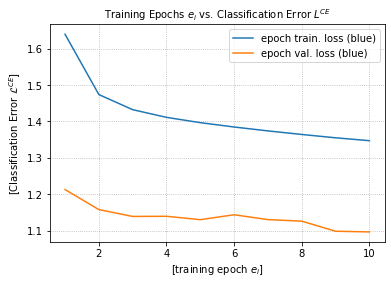

In [94]:
visualize_losses_during_training(train_epoch_losses, validation_epoch_losses)

In [96]:
y_pred = []
y_true = []
# iterate over test data
model.eval()
with torch.no_grad():
    for (images, labels) in tqdm(val_loader, desc="Predict labels"):
        images = images.to(device)

        outputs = model(images)  # Feed Network
        _, predicted = torch.max(outputs, 1)

        y_pred.extend(predicted.cpu().numpy())  # Save Prediction
        y_true.extend(labels.numpy())  # Save Truth

Predict labels: 100%|██████████| 338/338 [00:03<00:00, 104.50it/s]


In [97]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.54      0.55      0.55       612
           1       0.64      0.62      0.63       578
           2       0.59      0.37      0.46       631
           3       0.46      0.14      0.21       494
           4       0.81      0.75      0.78       482
           5       0.42      0.64      0.51       379
           6       0.37      0.48      0.42       507
           7       0.49      0.61      0.54       626
           8       0.53      0.58      0.55       519
           9       0.57      0.63      0.60       572

    accuracy                           0.54      5400
   macro avg       0.54      0.54      0.52      5400
weighted avg       0.54      0.54      0.53      5400



## Downstream Task: Segmentation

### Load data

In [98]:
import gdown

gdown.download(
    "https://drive.google.com/u/1/uc?id=1zGalZSCxgnmZM7zMm0qfRrnOXyD6IUX1&export=download"
)

Downloading...
From: https://drive.google.com/u/1/uc?id=1zGalZSCxgnmZM7zMm0qfRrnOXyD6IUX1&export=download
To: /content/lab-seg-data.tar.gz
100%|██████████| 5.37G/5.37G [02:07<00:00, 42.3MB/s]


'lab-seg-data.tar.gz'

In [99]:
import tarfile
import os

data_base_path = "/content/"
data_folder = "lab-seg-data"
tar_path = os.path.join(data_base_path, data_folder + ".tar.gz")

with tarfile.open(tar_path, mode="r") as tar:
    tar.extractall(path=data_base_path)

In [102]:
# !pip install rasterio torchmetrics

In [104]:
class SEN12FLOODS:
    """SEN12FLOODS Segmentation Dataset."""

    def __init__(self, root="chips/", split="train", transforms=None, **kwargs):
        super(SEN12FLOODS, self).__init__()

        # Loop over available data and create pairs of Sentinel 1 and Sentinel 2 images, co-registered,
        # with corresponding groundtruth, and store the paths in lists.
        (
            self.s2_images,
            self.s2_masks,
            self.s1_images,
            self.s1_masks,
        ) = self._get_sen2flood_pairs(root, split)

        # Make sure that for each data point we have all the values we need.
        assert (
            len(self.s2_images)
            == len(self.s2_masks)
            == len(self.s1_images)
            == len(self.s1_masks)
        )
        if len(self.s2_images) == 0:
            raise RuntimeError("Found 0 images in subfolders of:" + root + "\n")

        print(
            "Found {} images in the folder {}".format(len(self.s2_images), root + split)
        )

        self.transforms = transforms

        # Initialise the data augmentation we will use: horizontal and vertical flipping, random affine translation, resizing
        if self.transforms:
            augmentation = A.Compose(
                [
                    A.Resize(
                        height=256, width=256, p=1, interpolation=cv2.INTER_NEAREST
                    ),
                    A.Affine(scale=2, translate_px=5, rotate=20, p=0.5),
                    A.HorizontalFlip(p=0.5),
                    A.VerticalFlip(p=0.5),
                    ToTensorV2(),
                ],
                additional_targets={"image0": "image"},
            )
            self.augmentation = augmentation

        else:
            augmentation = A.Compose(
                [
                    A.Resize(
                        height=256, width=256, p=1, interpolation=cv2.INTER_NEAREST
                    ),
                    ToTensorV2(),
                ],
                additional_targets={"image0": "image"},
            )
            self.augmentation = augmentation

        # turn lists into arrays
        self.s2_images = np.array(self.s2_images)
        self.s1_images = np.array(self.s1_images)
        self.s2_masks = np.array(self.s2_masks)
        self.s1_masks = np.array(self.s1_masks)

    def __len__(self):
        return len(self.s2_images)

    def __getitem__(self, index):
        # Loop over all bands, and create a concatenated array for sentinel-2 data
        bands = []
        for file in [
            "B1.tif",
            "B2.tif",
            "B3.tif",
            "B4.tif",
            "B5.tif",
            "B6.tif",
            "B7.tif",
            "B8.tif",
            "B8A.tif",
            "B9.tif",
            "B10.tif",
            "B11.tif",
            "B12.tif",
        ]:
            band = rio.open(os.path.join(self.s2_images[index], file))
            bands.append(band.read())
        s2_img = np.concatenate(bands, axis=0)
        s2_img = np.array(s2_img, dtype=np.float32)
        # print(s2_img.shape)

        # Loop over both polarization, and create a concatenated array for sentinel-1 data
        bands = []
        for file in ["VH.tif", "VV.tif"]:
            band = rio.open(os.path.join(self.s1_images[index], file))
            band_array = band.read()
            if np.isfinite(band_array).all():
                bands.append(band.read())
            else:
                bands.append(np.zeros(band_array.shape))
        s1_img = np.concatenate(bands, axis=0)
        s1_img = np.array(s1_img, dtype=np.float32)

        # The two channels of Sentinel-1 (VV and VH) have both negative and positive values.
        # We normalize them to lie between 0 and 1 by applying [min-max normalization with min = -77 and max = 26.
        s1_img = np.clip(s1_img, a_min=-77, a_max=26)
        s1_img = (s1_img + 77) / (26 + 77)

        # The water labels for Sentinel 1 and Sentinel 2 can be slightly different (since scenes are taken around 3 days apart)
        # We read the water label mask associated to Sentinel 2.
        mask = rio.open(self.s2_masks[index])
        mask_img = mask.read().squeeze()

        # Apply same data augmentation for both sentinel 2 and sentinel 1 images, and the mask.
        augmented_data = self.augmentation(
            image=np.transpose(s2_img, (1, 2, 0)),
            image0=np.transpose(s1_img, (1, 2, 0)),
            mask=mask_img,
        )

        # Define output tensor
        output_tensor = {
            "s2_img": augmented_data["image"],
            "s1_img": augmented_data["image0"],
            "s2_imgfile": self.s2_images[index],
            "s1_imgfile": self.s1_images[index],
            "mask": augmented_data["mask"],
            # "mask": np.expand_dims(augmented_data['mask'], axis=0),
        }

        return output_tensor

    def _get_sen2flood_pairs(self, folder, split):
        """
        Constructs Sentinel2 and Sentinel1 pairs

        Arguments
        ----------
            folder : str
                Image folder name
            split : str
                train or val split
        Returns
        -------
            s2_img_paths : list
                List of Sentinel 2 image path
            s2_mask_paths : list
                List of Sentinel 2 water mask path
            s1_img_paths : list
                List of Sentinel 1 image path
            s1_mask_paths : list
                List of Sentinel 1 water mask path
        """
        s2_img_paths = []
        s2_mask_paths = []
        s1_img_paths = []
        s1_mask_paths = []

        img_folder = os.path.join(folder, split)

        # loop over the image folder (train or validation)
        for filename in os.listdir(img_folder):
            if filename not in ["._.DS_Store", ".DS_Store"]:
                for file in os.listdir(os.path.join(img_folder, filename, "s2")):
                    if file not in ["._.DS_Store", ".DS_Store"]:
                        # Get the Image ID (as explained in the dataset section)
                        image_id = file.split("_")[-1]

                        # Store Sentinel 2 image and mask paths in lists
                        s2_imgpath = os.path.join(img_folder, filename, "s2", file)
                        s2_maskpath = os.path.join(
                            img_folder, filename, "s2", file, "LabelWater.tif"
                        )

                        # Using the Image ID, store co-registered Sentinel 1 image and mask paths in lists
                        s1_files = os.listdir(os.path.join(img_folder, filename, "s1"))
                        s1_file = [
                            file for file in s1_files if file.endswith(image_id)
                        ][0]
                        s1_imgpath = os.path.join(img_folder, filename, "s1", s1_file)
                        s1_maskpath = os.path.join(
                            img_folder, filename, "s1", s1_file, "LabelWater.tif"
                        )

                        if os.path.isfile(s1_maskpath):
                            s2_img_paths.append(s2_imgpath)
                            s2_mask_paths.append(s2_maskpath)
                            s1_img_paths.append(s1_imgpath)
                            s1_mask_paths.append(s1_maskpath)
                        else:
                            print("cannot find the S1 Mask:", s1_maskpath)

        return s2_img_paths, s2_mask_paths, s1_img_paths, s1_mask_paths

    def visualize_observation(self, idx):
        """
        Visualise Sentinel1, Sentinel2, and water mask.

        Arguments
        ----------
            idx : int
                Data index
        """
        sample = self.__getitem__(idx)

        s2_image = sample.get("s2_img").squeeze()
        s1_image = sample.get("s1_img").squeeze()
        mask = sample.get("mask")

        print(sample.get("s2_imgfile"))
        print(sample.get("s1_imgfile"))

        fig, axs = plt.subplots(1, 3, figsize=(17, 6))

        s1_img_vh = s1_image[0, :, :]
        s1_img_vh = s1_img_vh / s1_img_vh.max()

        axs[0].imshow(s1_img_vh)
        axs[0].set_title("Sentinel-1 VH")
        axs[0].axis("off")

        s2_img_rgb = s2_image[[3, 2, 1], :, :]
        s2_img_rgb = np.transpose(s2_img_rgb, (1, 2, 0))
        s2_img_rgb = s2_img_rgb / s2_img_rgb.max()

        axs[1].imshow(s2_img_rgb)
        axs[1].set_title("Sentinel-2 RGB")
        axs[1].axis("off")

        mask = mask.squeeze()

        axs[2].imshow(mask, cmap="Blues")
        axs[2].set_title("Groundtruth Mask")
        axs[2].axis("off")

        plt.show()

In [107]:
trainset = SEN12FLOODS(root="/content/chips/", transforms=True, split="train")

valset = SEN12FLOODS(root="/content/chips/", split="val")


train_loader_flood = DataLoader(trainset, batch_size=8, pin_memory=True)

val_loader_flood = DataLoader(valset, batch_size=8, pin_memory=True)

Found 688 images in the folder /content/chips/train
Found 211 images in the folder /content/chips/val


In [110]:
next(iter(train_loader_flood))["mask"].shape

torch.Size([8, 256, 256])

In [111]:
next(iter(train_loader_flood))["s2_img"].shape

torch.Size([8, 13, 256, 256])

/content/chips/train/e92c811f-ba53-4df2-aad0-afea8b733621/s2/S2B_MSIL1C_20190906T101029_N0208_R022_T31PCR_20190906T135347_05632-06656
/content/chips/train/e92c811f-ba53-4df2-aad0-afea8b733621/s1/S1A_IW_GRDH_1SDV_20190909T180355_20190909T180420_028948_034852_CA54_05632-06656


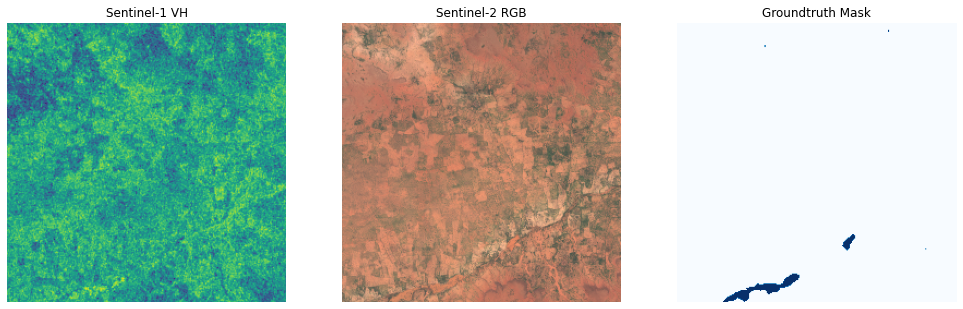

In [116]:
trainset.visualize_observation(100)

## Model

In [117]:
new_in_channels = 13

In [118]:
def patch_first_conv(encoder, new_in_channels, default_in_channels=3):

    for module in encoder.modules():
        if isinstance(module, nn.Conv2d) and module.in_channels == 3:
            print(module)
            break

    weight = module.weight.detach()
    module.in_channels = 13

    new_weight = torch.Tensor(
        module.out_channels, new_in_channels // module.groups, *module.kernel_size
    )
    for i in range(new_in_channels):
        new_weight[:, i] = weight[:, i % default_in_channels]

    new_weight = new_weight * (default_in_channels / new_in_channels)
    module.weight = nn.parameter.Parameter(new_weight)

In [120]:
patch_first_conv(best_model_encoder, 13)

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


In [121]:
import torch
import torch.nn as nn


def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )


class ResNetUNet(nn.Module):
    def __init__(self, n_class, encoder=None):
        super().__init__()

        # test base mode: pretrained resnet 18 of imagenet
        # self.base_model = torchvision.models.resnet18(pretrained=True)
        # base model from our pre-trained model
        # patch_first_conv
        self.base_model = encoder
        self.base_layers = list(self.base_model.children())

        self.layer0 = nn.Sequential(*self.base_layers[:3])  # size=(N, 64, x.H/2, x.W/2)
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(
            *self.base_layers[3:5]
        )  # size=(N, 64, x.H/4, x.W/4)
        self.layer1_1x1 = convrelu(64, 64, 1, 0)
        self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
        self.layer2_1x1 = convrelu(128, 128, 1, 0)
        self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
        self.layer3_1x1 = convrelu(256, 256, 1, 0)
        self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
        self.layer4_1x1 = convrelu(512, 512, 1, 0)

        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)

        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

        # from 3 to 13
        self.conv_original_size0 = convrelu(13, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

        self.conv_last = nn.Conv2d(64, n_class, 1)

    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)

        layer0 = self.layer0(input)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)

        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        # concat: skip connection to merge features from z_layer3
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)

        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        # concat: skip connection to merge features from z_layer2
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        # concat: skip connection to merge features from z_layer1
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)

        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)

        out = self.conv_last(x)

        return out

In [149]:
# test block
import torchvision

best_model_encoder = torchvision.models.resnet18(pretrained=True)
bst_encoder = deepcopy(best_model_encoder)
patch_first_conv(bst_encoder, 13, default_in_channels=3)

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


In [157]:
# our pretrained weights
bst_encoder = deepcopy(best_model.encoder)
patch_first_conv(bst_encoder, 13, default_in_channels=3)

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


In [158]:
# our pretrained model
model = ResNetUNet(1, encoder=bst_encoder)

In [159]:
# from torchsummary import summary
# summary(model.to(device), input_size=(13, 256, 256))

In [160]:
# # freeze backbone layers
# for l in model.base_layers:
#   for param in l.parameters():
#     param.requires_grad = False

In [161]:
model = model.to(device)

## Training

In [162]:
# Define a learning rate
learning_rate = 0.001

# Initialise the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [163]:
# Initialise the loss function and move it to the GPU if available
criterion = torch.nn.BCEWithLogitsLoss().to(device)

In [164]:
next(iter(train_loader_flood))["s2_img"].shape

torch.Size([8, 13, 256, 256])

In [165]:
# We will use the tqdm library to display the progress of our training.
# from tqdm.autonotebook import tqdm
from tqdm import tqdm
from torchmetrics import JaccardIndex
import os

epochs = train_config.segmentation_epochs

# Move the model to the GPU
model.to(device)

# Create lists for logging losses and evalualtion metrics:
train_losses = []
train_accs = []
train_ious = []

val_losses = []
val_accs = []
val_ious = []

# IoU
jaccard = JaccardIndex(num_classes=2).to(device)


# For every epoch
for epoch in range(epochs):
    epoch_loss = 0
    progress = tqdm(
        enumerate(train_loader_flood),
        desc="Train Loss: ",
        total=len(train_loader_flood),
    )

    # Specify you are in training mode
    model.train()

    epoch_train_loss = 0
    epoch_val_loss = 0

    epoch_train_ious = 0
    epoch_val_ious = 0

    epoch_train_accs = 0
    epoch_val_accs = 0

    for i, batch in progress:
        # Transfer data to GPU if available
        data = batch["s2_img"].float().to(device)
        label = batch["mask"].float().to(device)

        # Make a forward pass
        output = model(data)
        # print(output.shape)

        # Derive binary segmentation map from prediction
        output_binary = torch.zeros(output.shape)
        output_binary[output >= 0] = 1

        # Compute IoU
        epoch_train_ious += jaccard(output_binary.to(device), label.int()) / len(
            train_loader_flood
        )

        # Compute pixel accuracies
        epoch_train_accs += torch.sum(output_binary.to(device) == label.int()) / (
            len(train_loader_flood) * (256 * 256) * 100
        )

        # Compute the loss
        loss = criterion(output, label.unsqueeze(1))

        # Clear the gradients
        optimizer.zero_grad()

        # Calculate gradients
        loss.backward()

        # Update Weights
        optimizer.step()

        # Accumulate the loss over the eopch
        epoch_train_loss += loss / len(train_loader_flood)

        progress.set_description(
            "Epoch = {}, Train Loss: {:.4f}".format(epoch + 1, epoch_train_loss)
        )

    progress = tqdm(
        enumerate(val_loader_flood),
        desc="val Loss: ",
        total=len(val_loader_flood),
        position=0,
        leave=True,
    )

    # Specify you are in evaluation mode
    model.eval()

    # Deactivate autograd engine (no backpropagation allowed)
    with torch.no_grad():
        epoch_val_loss = 0
        for j, batch in progress:
            # Transfer Data to GPU if available
            data = batch["s2_img"].float().to(device)
            label = batch["mask"].float().to(device)

            # Make a forward pass
            output = model(data)

            # Derive binary segmentation map from prediction
            output_binary = torch.zeros(output.shape)
            output_binary[output >= 0] = 1

            # Compute IoU
            epoch_val_ious += jaccard(output_binary.to(device), label.int()) / len(
                val_loader_flood
            )

            # Compute pixel accuracies
            epoch_val_accs += torch.sum(output_binary.to(device) == label.int()) / (
                len(val_loader_flood) * (256 * 256) * 100
            )

            # Compute the loss
            val_loss = criterion(output, label.unsqueeze(1))

            # Accumulate the loss over the epoch
            epoch_val_loss += val_loss / len(val_loader_flood)

            progress.set_description("Validation Loss: {:.4f}".format(epoch_val_loss))

    if epoch == 0:
        best_val_loss = epoch_val_loss
    else:
        if epoch_val_loss <= best_val_loss:
            best_val_loss = epoch_val_loss
            # Save only the best model
            save_weights_path = os.path.join(save_model_path, "segmentation_model.pth")
            torch.save(model.state_dict(), save_weights_path)
            print("Saving Model...")

    # print("Epoch = ", epoch+1)
    # Save losses in list, so that we can visualise them later.
    train_losses.append(epoch_train_loss.cpu().detach().numpy())
    val_losses.append(epoch_val_loss.cpu().detach().numpy())

    # Save IoUs in list, so that we can visualise them later.
    train_ious.append(epoch_train_ious.cpu().detach().numpy())
    val_ious.append(epoch_val_ious.cpu().detach().numpy())
    print(f"train_iou is {epoch_train_ious:.4f}, val_iou is {epoch_val_ious:.4f}")

    # Save accuracies in list, so that we can visualise them later.
    train_accs.append(epoch_train_accs.cpu().detach().numpy())
    val_accs.append(epoch_val_accs.cpu().detach().numpy())
    print(f"train_acc is {epoch_train_accs:.4f}, val_acc is {epoch_val_accs:.4f}")

print("Finished Training")

Validation Loss: 0.3258: 100%|██████████| 27/27 [00:22<00:00,  1.20it/s]


train_iou is 0.5656, val_iou is 0.7319
train_acc is 0.5248, val_acc is 0.4767


Validation Loss: 0.2724: 100%|██████████| 27/27 [00:22<00:00,  1.18it/s]


Saving Model...
train_iou is 0.6446, val_iou is 0.6148
train_acc is 0.5468, val_acc is 0.5197


Validation Loss: 0.1407: 100%|██████████| 27/27 [00:22<00:00,  1.20it/s]


Saving Model...
train_iou is 0.7190, val_iou is 0.7932
train_acc is 0.5496, val_acc is 0.5013


Validation Loss: 0.1336: 100%|██████████| 27/27 [00:22<00:00,  1.19it/s]


Saving Model...
train_iou is 0.7233, val_iou is 0.7782
train_acc is 0.5494, val_acc is 0.5036


Validation Loss: 0.1202: 100%|██████████| 27/27 [00:22<00:00,  1.20it/s]


Saving Model...
train_iou is 0.7163, val_iou is 0.8033
train_acc is 0.5483, val_acc is 0.4975


Validation Loss: 0.1908: 100%|██████████| 27/27 [00:22<00:00,  1.19it/s]


train_iou is 0.7240, val_iou is 0.7562
train_acc is 0.5424, val_acc is 0.5079


Epoch = 7, Train Loss: 0.0257:  34%|███▎      | 29/86 [00:32<01:04,  1.13s/it]


KeyboardInterrupt: ignored

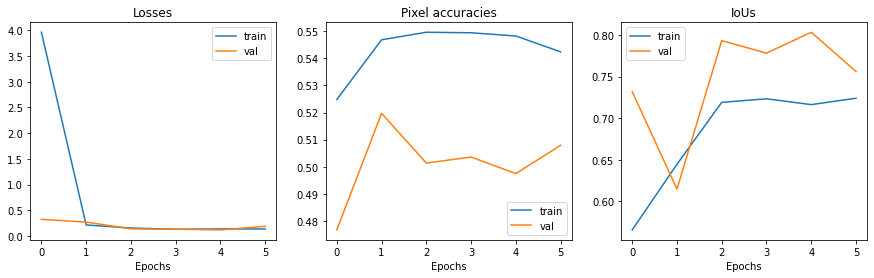

In [166]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(train_losses, label="train")
axes[0].plot(val_losses, label="val")
axes[0].set_xlabel("Epochs")
axes[0].set_title("Losses")
axes[0].legend()

axes[1].plot(train_accs, label="train")
axes[1].plot(val_accs, label="val")
axes[1].set_xlabel("Epochs")
axes[1].set_title("Pixel accuracies")
axes[1].legend()

axes[2].plot(train_ious, label="train")
axes[2].plot(val_ious, label="val")
axes[2].set_xlabel("Epochs")
axes[2].set_title("IoUs")
axes[2].legend()

In [167]:
# Initialise a UNet() model
# ResNetUNet(1,encoder = best_model.encoder)
ResNetUNet(1, encoder=torchvision.models.resnet18(pretrained=True))
# Load pretrained weights
model.load_state_dict(
    torch.load(os.path.join(save_model_path, "segmentation_model.pth"))
)
# Move to device (GPU or CPU)
model.to(device);

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [168]:
from sklearn.metrics import confusion_matrix, accuracy_score, jaccard_score


def get_metrics(true, preds):
    matrix = confusion_matrix(true.flatten(), preds.flatten())
    class_0, class_1 = matrix.diagonal() / matrix.sum(axis=1)
    print("***************** Metrics *****************")
    print("Class 0 (no water) accuracy: {:.3f}".format(class_0))
    print("Class 1 (water) accuracy: {:.3f}".format(class_1))
    print(
        "Overall accuracy: {:.3f}".format(
            accuracy_score(true.flatten(), preds.flatten())
        )
    )
    print("Equally Weighted accuracy: {:.3f}".format(0.5 * class_0 + 0.5 * class_1))
    print("IoU: {:.3f}".format(jaccard_score(true.flatten(), preds.flatten())))
    print("*******************************************")

In [169]:
import random


def display_outputs(idx=None, multi=False):
    # Pick a random index if none is specified
    if not idx:
        idx = random.randint(0, len(valset))
    print("Validation image ID: {}".format(idx))

    # Get Sentinel 2 and Sentinel 1 data
    s2_data = torch.unsqueeze(valset.__getitem__(idx)["s2_img"].float().to(device), 0)
    s1_data = torch.unsqueeze(valset.__getitem__(idx)["s1_img"].float().to(device), 0)

    # Get predictions from the model
    if multi:
        output = model(s1_data, s2_data)
    else:
        output = model(s2_data)

    # Threshold the output to generate the binary map (FYI: the threshold value "0" can be tuned as any other hyperparameter)
    output_binary = torch.zeros(output.shape)
    output_binary[output >= 0] = 1

    get_metrics(valset.__getitem__(idx)["mask"], output_binary)

    fig, axes = plt.subplots(1, 3, figsize=(15, 7))
    axes[0].imshow(
        np.transpose(valset.__getitem__(idx)["s2_img"][[3, 2, 1], :, :], (1, 2, 0))
        / valset.__getitem__(idx)["s2_img"].max()
    )
    axes[0].set_title("True Color Sentinel-2")
    axes[2].imshow(valset.__getitem__(idx)["mask"], cmap="Blues")
    axes[2].set_title("Groundtruth")
    axes[1].imshow(output_binary.squeeze(), cmap="Blues")
    axes[1].set_title("Predicted Mask")

Validation image ID: 30
***************** Metrics *****************
Class 0 (no water) accuracy: 0.974
Class 1 (water) accuracy: 0.606
Overall accuracy: 0.878
Equally Weighted accuracy: 0.790
IoU: 0.564
*******************************************


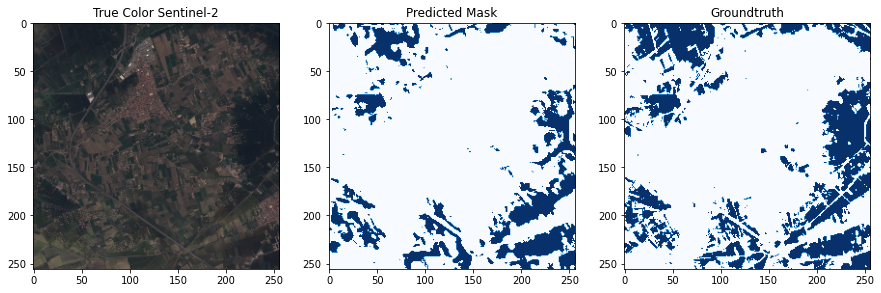

In [170]:
display_outputs()